# Problem statement

The idea is to forecast the mean of Invasive ventilators available in the US in the coming 1 year based on the historical data we're having and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [1]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs.csv')


# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2020-01-03       0.0000        0.0000        0.0000   
1   2       Abruzzo  2020-01-04       0.0000        0.0000        0.0000   
2   3       Abruzzo  2020-01-05       0.0000        0.0000        0.0000   
3   4       Abruzzo  2020-01-06       0.0000        0.0000        0.0000   
4   5       Abruzzo  2020-01-07       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  newICU_upper  \
0       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
1       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
2       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
3       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
4       0.0000        0.0000        0.0000       0.0000  ...        0.0000   

   totdea_mean  totdea_lower  totdea_upper  bedover_mean  bedover_lower  \

# Data pre-processing

* We're grouping by date and applying sum because we have data on states and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all those rows which have zeroes in mean, lower bound and upper bound columns

In [4]:
data = data[['date', 'InvVen_mean',  'InvVen_lower',  'InvVen_upper']] .groupby(['date']).sum().reset_index()
data = data[(data['InvVen_mean']!=0) & (data['InvVen_lower']!=0) & (data['InvVen_upper']!=0)]

In [5]:
# Fetching only columns of interest
InvVenData = data[['date', 'InvVen_mean']]
InvVenData.head()

,date,InvVen_mean
47,2020-02-19,14.0000
48,2020-02-20,20.0000
49,2020-02-21,30.0000
50,2020-02-22,44.8616
51,2020-02-23,59.6926


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [6]:
InvVenData['date'] = pd.to_datetime(InvVenData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final invasive ventilators value corresponding to each date.

### Grouping the column by date

In [7]:
InvVenData = InvVenData.groupby(['date']).sum().reset_index()
InvVenData.iloc[50:100]

,date,InvVen_mean
50,2020-04-09,68105.5997
51,2020-04-10,69163.3055
52,2020-04-11,69666.1344
53,2020-04-12,70152.3573
54,2020-04-13,71302.2334
55,2020-04-14,72196.8523
56,2020-04-15,69541.9313
57,2020-04-16,67684.8152
58,2020-04-17,66060.6549
59,2020-04-18,63972.7197


In [8]:
#setting index to date
InvVenData = InvVenData.set_index('date')
InvVenData.index

DatetimeIndex(['2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28',
               ...
               '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02',
               '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08'],
              dtype='datetime64[ns]', name='date', length=141, freq=None)

In [9]:
# Keeping historical data till 25th April 2020
InvVenData = InvVenData[InvVenData.index <= '2020-04-25']
InvVenData.columns = ['value']
InvVenData.tail()

,value
date,
2020-04-21,58881.8253
2020-04-22,55737.7532
2020-04-23,52713.5734
2020-04-24,49541.6853
2020-04-25,46038.8484


### Missing value analysis

We'll check is there's any missing value present in our data by applying isnull function on the dataset.

In [10]:
InvVenData.isnull().any()

value    False
dtype: bool

Since, we get False as the result, we can say that there're no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

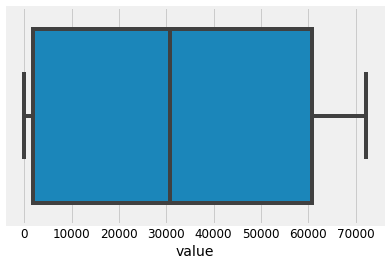

In [11]:
import seaborn as sns
sns.boxplot(x=InvVenData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [12]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(InvVenData))
print(z)

[[1.15562923]
 [1.15541465]
 [1.15505701]
 [1.1545255 ]
 [1.15399509]
 [1.15328382]
 [1.15286536]
 [1.15145316]
 [1.14937112]
 [1.14720561]
 [1.14382303]
 [1.13946196]
 [1.13724241]
 [1.12754848]
 [1.12053607]
 [1.10799062]
 [1.09454819]
 [1.07934628]
 [1.05846631]
 [1.04920073]
 [1.01523392]
 [0.9822151 ]
 [0.95436997]
 [0.91176472]
 [0.86567168]
 [0.79336641]
 [0.7222842 ]
 [0.65451687]
 [0.5740568 ]
 [0.472479  ]
 [0.37184177]
 [0.28582847]
 [0.17327981]
 [0.05271718]
 [0.04674922]
 [0.14162189]
 [0.28002477]
 [0.41490943]
 [0.52790322]
 [0.64186304]
 [0.76069306]
 [0.82844243]
 [0.86041868]
 [0.97581595]
 [1.04814403]
 [1.11605383]
 [1.19583856]
 [1.29010804]
 [1.30518724]
 [1.24689325]
 [1.2795792 ]
 [1.31740669]
 [1.33538972]
 [1.35277885]
 [1.39390269]
 [1.42589759]
 [1.33094775]
 [1.26453039]
 [1.20644438]
 [1.13177207]
 [1.0796304 ]
 [0.99552412]
 [0.94970278]
 [0.83725909]
 [0.72910319]
 [0.6156647 ]
 [0.49039024]]


As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [13]:
# Converting allBedData into time-series
ts = InvVenData['value']
ts.head()

date
2020-02-19   14.0000
2020-02-20   20.0000
2020-02-21   30.0000
2020-02-22   44.8616
2020-02-23   59.6926
Name: value, dtype: float64

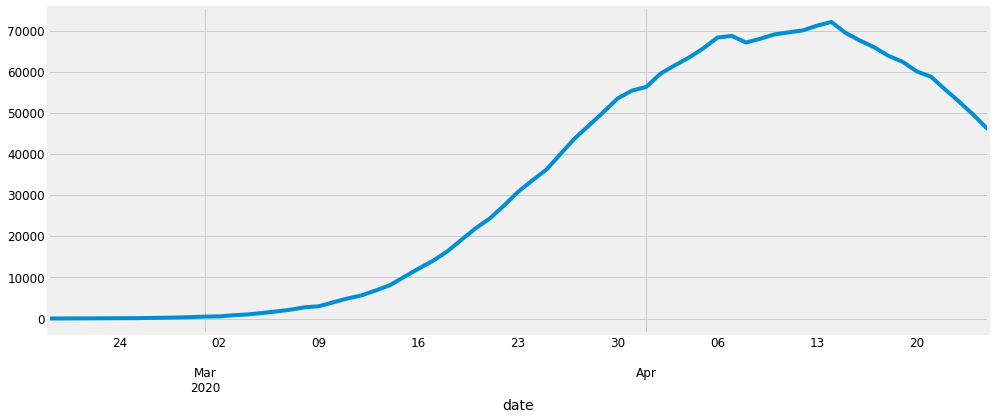

In [14]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increasing till mid April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

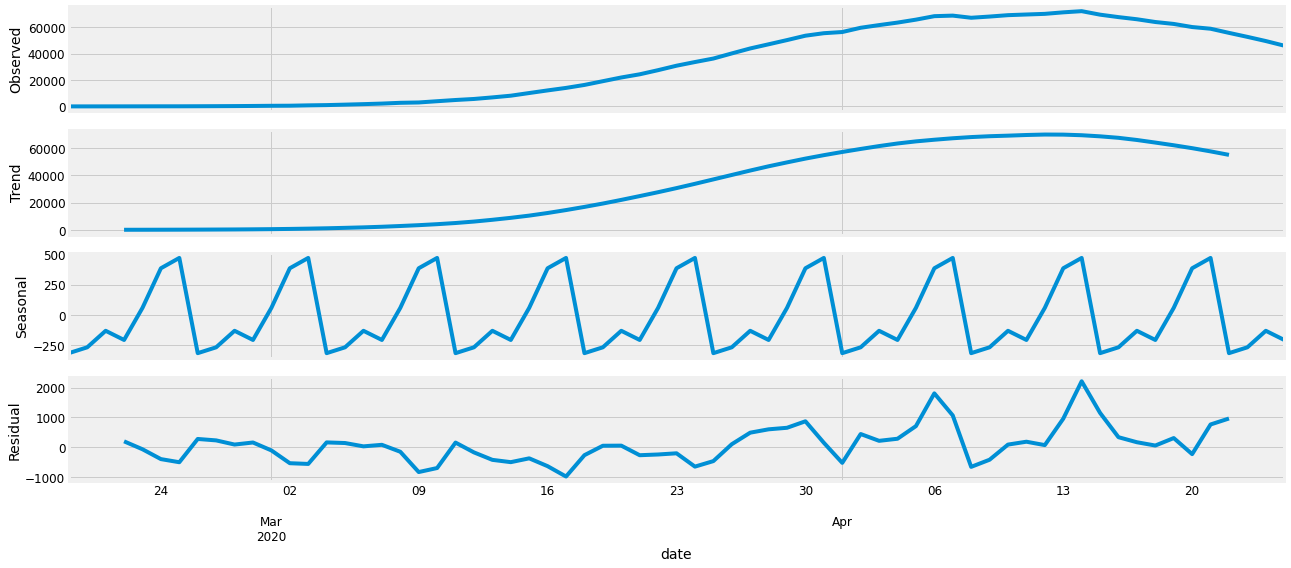

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking stationarity

 In a time series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables, hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

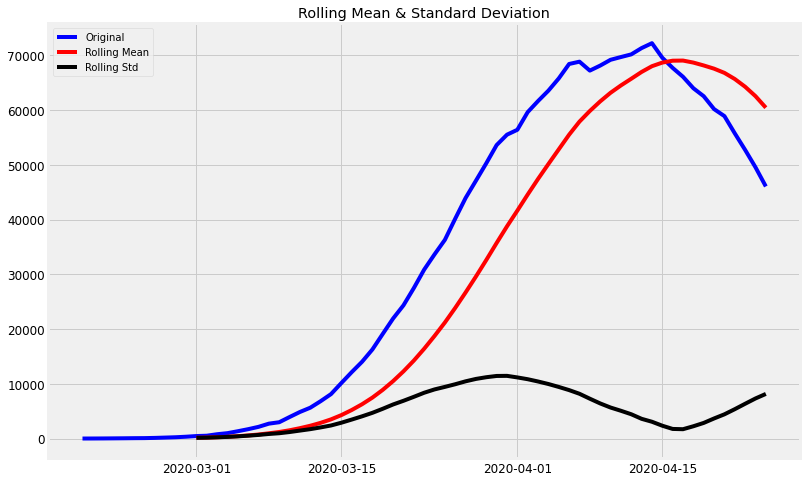

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.4063
p-value                        0.0000
#Lags Used                     7.0000
Number of Observations Used   59.0000
Critical Value (1%)           -3.5464
Critical Value (5%)           -2.9119
Critical Value (10%)          -2.5937
dtype: float64


In [17]:
test_stationarity(ts)

We can see that this time series is stationary with p value of 0.00.

# Plotting ACF and PACF 

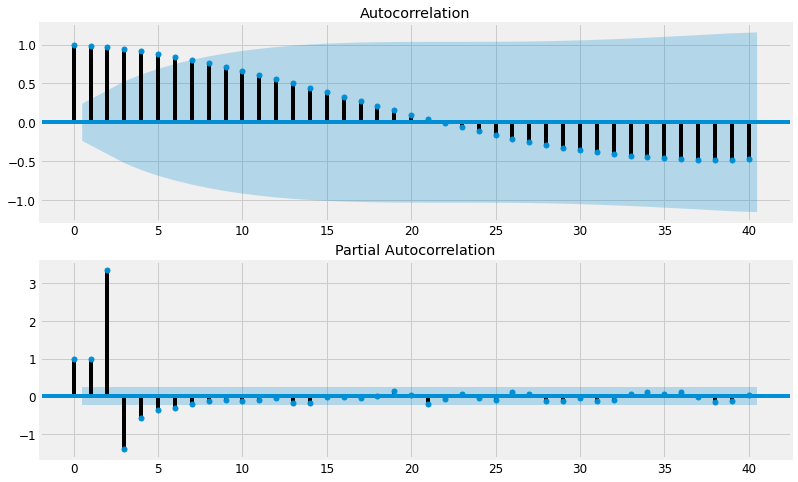

In [18]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 15 days, we're seeing some sine wave like pattern, let's consider SARIMA.